In [ ]:
#| code-fold: true
#| code-summary: "Show setup"
!pip install -qq diffusers transformers==4.46.2
!pip install -qq pillow==11.0.0

from diffusers import LMSDiscreteScheduler, AutoencoderKL, UNet2DConditionModel, StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision.transforms import ToTensor
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import display
import torch, math
import numpy as np

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

## Background

In Lesson 10 of the fastai course (Part 2) Jeremy assigns us the following homework assignment:

> try picking one of the extra tricks we learned about like image-to-image, or negative prompts; see if you can implement negative prompt 
in your version of this; or try doing image-to-image; try adding callbacks

In this blog post I’ll implement negative prompting using the diffusion loop code provided in the course’s 
[Stable Diffusion with Diffusers](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb) notebook.

I’ll start by copy/pasting all of the boilerplate code provided in that notebook, and running it to make sure we get the desired images.

In [4]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    #latents = latents.to("cuda").half() * scheduler.init_noise_sigma
    #latents = latents.to("cuda").half()
    latents = latents.to("cuda").half() * 15

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

/tmp/ipykernel_33/2843554848.py:17: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

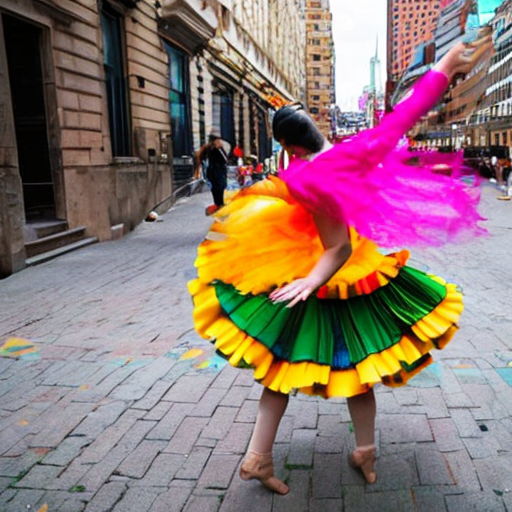

In [5]:
images = mk_samples(prompts=['A dancer wearing a colorful dress'])
for img in images: display(mk_img(img))

## Implementing Image-to-Image Generation

In the default implementation of the stable diffusion loop, we start out with a set of random latents:

```python
latents = torch.randn((bs, unet.in_channels, height//8, width//8))
latents = latents.to("cuda").half() * 15
```

What we want for image-to-image generation is to start with noisy latents for some initial image. This will involve:

- Loading an image as a tensor.
- Encoding the image into latents.
- Adding some noise to the latents.

### Loading an image as a tensor

I'll use this Macaw from Lesson 10 as the initial image.

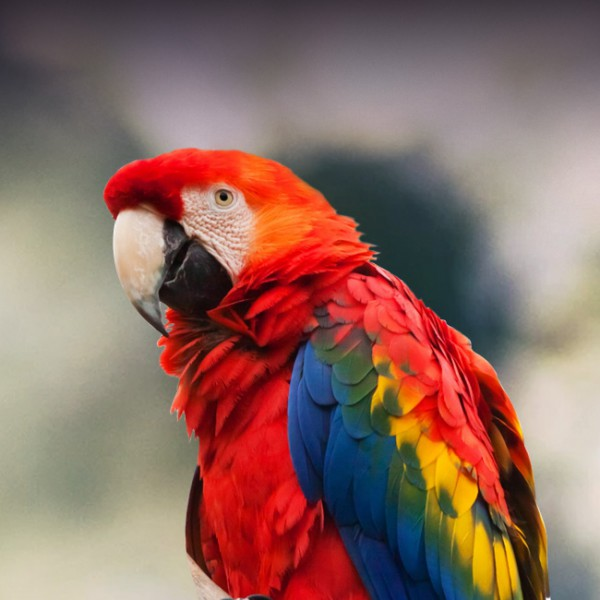

In [54]:
init_image_path = "macaw.jpg"
im = Image.open(init_image_path)
im

The original image contains values between `0` and `255`:

In [55]:
np.array(im).min(), np.array(im).max()

(0, 255)

The following lines load the image, resize it to the desired size (512x512) and convert it to a tensor using `torchvision.transforms.ToTensor`. 
I also make sure the image is on the GPU and is using `half`-precision (which is used by the VAE):

In [56]:
transform = ToTensor()
init_image = transform(Image.open(init_image_path).convert('RGB').resize((512, 512))).to("cuda").half()

The transformed image (to tensor) contains values between `0` and `1`:

In [57]:
init_image.min(), init_image.max()

(tensor(0., device='cuda:0', dtype=torch.float16),
 tensor(1., device='cuda:0', dtype=torch.float16))

### Encoding the image into latents

I reference the following line from `mk_img`:

```python
image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
```

and the following line from `mk_samples`:

```python
with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample
```

to encode the initial image into latents with the following line:

In [58]:
latents = vae.encode(init_image.unsqueeze(0)*2 - 1).latent_dist.sample() * 0.18215

In [59]:
latents.shape

torch.Size([1, 4, 64, 64])

Note that the VAE encoder expects values between `-1` and `1` so we have to transform the image tensor accordingly:

In [60]:
shifted_im = init_image.unsqueeze(0)*2 - 1
shifted_im.min(), shifted_im.max()

(tensor(-1., device='cuda:0', dtype=torch.float16),
 tensor(1., device='cuda:0', dtype=torch.float16))

### Adding some noise to the latents

We don't want to start the diffusion loop with the original image's latents because the UNet is trained to predict noise on noisy latents. 
In order to give the UNet it's expected input (noisy latents) we need to add noise to our initial image's latents!

We don't want to literally _add_ (with `+`) noise to the latents. Instead, we want to simulating the diffusion process as if it were starting from pure 
random noise. To do this, we need to prep the `scheduler` with the total number of `steps` (so it can calculate noise appropriately), pick some initial 
step for our noise, and add it to our latents with `add_noise`:

In [61]:
# set timesteps
steps = 70
scheduler.set_timesteps(steps)

# get start timestep
init_strength = 0.15 # can be anything 0-1
init_step = int(init_strength * steps)
ts_start = torch.tensor([scheduler.timesteps[init_step]])

# create noise
bs = 1
noise = torch.randn((bs, unet.in_channels, height//8, width//8)).to("cuda")

# add noise
latents = scheduler.add_noise(latents, noise, ts_start).half()

/tmp/ipykernel_33/3549084226.py:12: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  noise = torch.randn((bs, unet.in_channels, height//8, width//8)).to("cuda")


In [62]:
latents.shape

torch.Size([1, 4, 64, 64])

Note that `init_step` and `ts_start` are two different values.

In [63]:
init_step, ts_start

(10, tensor([854.2174]))

### Running the diffusion loop

I'll define some of the related inputs so I can run the diffusion loop with our initial image's noisy latents. Note that we are not starting the 
diffusion loop with the first `ts` but rather starting at the `init_step` we calculated above:

In [34]:
prompts=['A dancer wearing a colorful dress']
g = 7.5
seed = 100

bs = len(prompts)
text = text_enc(prompts)
uncond = text_enc([""] * bs, text.shape[1])
emb = torch.cat([uncond, text])
if seed: torch.manual_seed(seed)

In [35]:
for i,ts in enumerate(tqdm(scheduler.timesteps[init_step:])):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

with torch.no_grad(): 
    final_image = vae.decode(1 / 0.18215 * latents).sample

  0%|          | 0/60 [00:00<?, ?it/s]

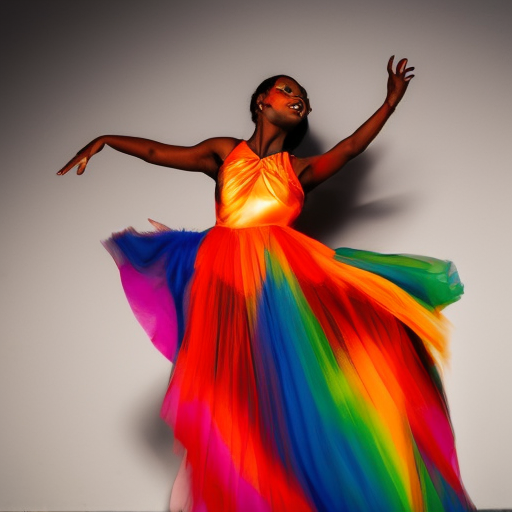

In [36]:
display(mk_img(final_image[0]))

As a reminder, here is the initial image, we can see the similarities in color structure (note the transitions from red --> blue --> 
green --> yellow).

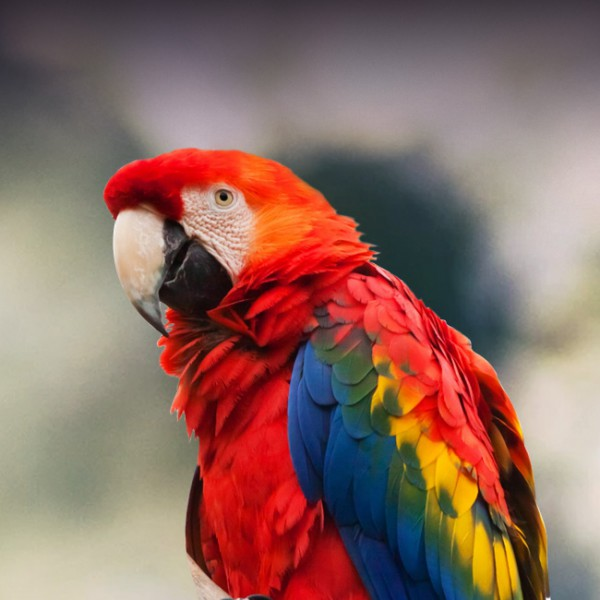

In [18]:
Image.open(init_image_path)

## Varying `init_strength`

With the core functionality of image-to-image generation working properly, I'll wrap it all into a function so I can loop through different `init_strength` 
values to see how it affects the generated image.

In [37]:
def mk_samples(prompts, init_image_path, g=7.5, seed=100, steps=70, init_strength=0.15):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    # load image as tensor
    transform = ToTensor()
    init_image = transform(Image.open(init_image_path).convert('RGB').resize((512, 512))).to("cuda").half()

    # encode image into latents
    latents = vae.encode(init_image.unsqueeze(0)*2 - 1).latent_dist.sample() * 0.18215

    # set timesteps
    scheduler.set_timesteps(steps)

    # get start timestep
    init_step = int(init_strength * steps)
    ts_start = torch.tensor([scheduler.timesteps[init_step]])

    # create noise
    noise = torch.randn((bs, unet.in_channels, height//8, width//8)).to("cuda")

    # add noise
    latents = scheduler.add_noise(latents, noise, ts_start).half()

    for i,ts in enumerate(tqdm(scheduler.timesteps[init_step:])):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample
    

In [ ]:
imgs = []
for i in range(100):
  images = mk_samples(prompts=["A dancer wearing a colorful dress"], init_image_path="macaw.jpg", init_strength=i*0.01)
  imgs.append(images[0])

In [39]:
imgs = [mk_img(img.squeeze()) for img in imgs]

In [40]:
imgs[0].save(f'init_strength.gif', save_all=True, append_images=imgs[1:], duration=100, loop=0)

![`init_strength` goes from 0 to 1.0](init_strength.gif)

As `init_strength` goes from `0.0` (totally random initial noise) to `0.99` (very lightly noised initial image) we can see how the prompt conforms 
to the color and structure of the initial image.

## Final Thoughts

Working through this implementation solidified my understanding of the diffusion loop. A few small but key points that I paid more attention to this 
time around:

- The VAE encoder expects latent values between `-1` and `1` so we have to transform our image tensor accordingly.
- Adding noise to our initial image's latents requires:
    - Picking a total number of inference steps.
    - Picking an initial step (at which we will apply the noise) and the corresponding `scheduler` timestep.
    - Using `scheduler.add_noise`.
- The text encoding process remains untouched.
- The only change to the diffusion loop is starting at `scheduler.timesteps[init_step]` instead of the first timestep.

The last implementation for this HW assignment will be to implement callbacks, which I'll do in a future blog post! Thanks for reading!